In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm 
from sklearn.metrics import mean_squared_error

Data Import and Cleaning


In [105]:
data = pd.read_csv('VIX_data.csv')

In [106]:
data.head()

,Date,Unemployment Rate,CPI,Three Month T Bill Rate,Six Month T Bill Rate,10-Year Treasury Constant Maturity Rate,Fed Rate,BBB Rate,SP500 Index,VIX_x,...,USD INDEX Open,USD INDEX High,USD INDEX Low,USD INDEX Close,USD INDEX Adj Close,VXN Open,VXN High,VXN Low,VXN Close,VXN Adj Close
0,2014-09-01,5.9,237.477,0.02,0.04,2.53,0.09,3.54,1975.045,12.880,...,82.760002,86.220001,82.750000,85.940002,85.940002,12.71,19.100000,12.710000,18.260000,18.260000
1,2014-10-01,5.7,237.430,0.02,0.05,2.30,0.09,3.50,1946.160,16.530,...,85.910004,87.129997,84.470001,86.879997,86.879997,18.26,31.170000,15.310000,15.810000,15.810000
2,2014-11-01,5.8,236.983,0.02,0.07,2.33,0.09,3.63,2039.820,13.330,...,87.080002,88.440002,86.879997,88.360001,88.360001,15.74,17.180000,13.480000,14.740000,14.740000
3,2014-12-01,5.6,236.252,0.03,0.11,2.21,0.12,3.78,2063.890,15.155,...,88.230003,90.330002,87.629997,90.269997,90.269997,14.74,24.080000,14.300000,19.639999,19.639999
4,2015-01-01,5.7,234.747,0.03,0.08,1.88,0.11,3.64,2024.465,19.455,...,90.360001,95.480003,90.330002,94.800003,94.800003,19.73,23.700001,16.389999,21.590000,21.590000


In [107]:
data = data.dropna()

In [108]:
data.index = pd.to_datetime(data['Date'])

VIX_data = data['VIX_x']

In [109]:
VIX_data.describe()

count    104.000000
mean      17.471394
std        5.705616
min       10.005000
25%       13.170000
50%       15.915000
75%       21.057500
max       41.380000
Name: VIX_x, dtype: float64

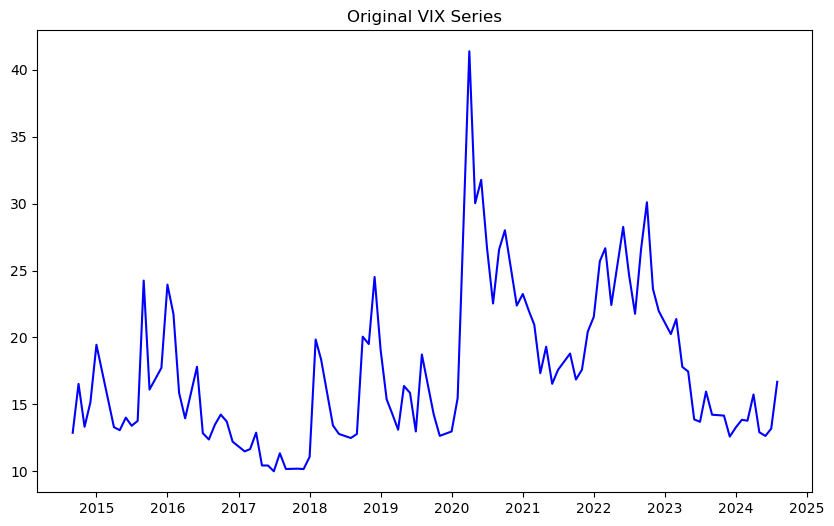

In [110]:
#Exploratory Data Analysis
plt.figure(figsize=(10,6))
plt.plot(VIX_data, color='blue')
plt.title('Original VIX Series')
plt.show()

Checking Stationarity

- Method 1 - Rolling Statistics
- Method 2 - Duckey fuller

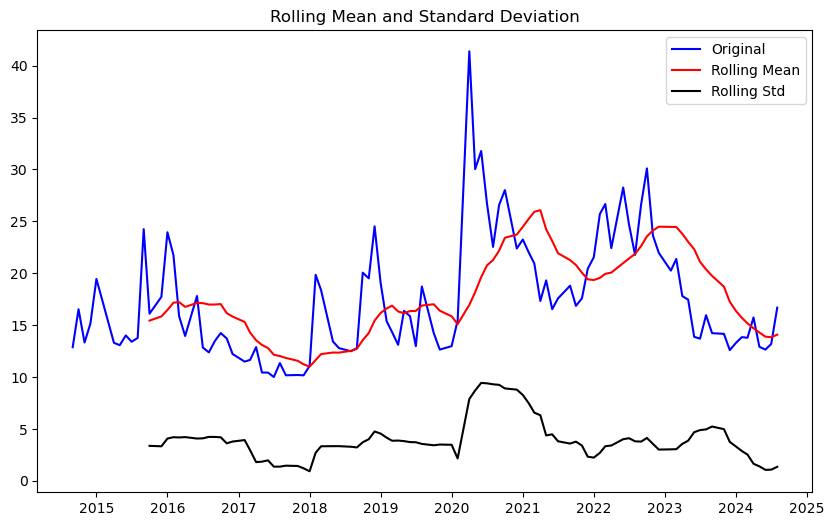

In [111]:
#Determining rolling statistics
rolLmean = VIX_data.rolling(12).mean()
rolLstd = VIX_data.rolling(12).std()

plt.figure(figsize=(10,6))
plt.plot(VIX_data, color='blue', label='Original')
plt.plot(rolLmean, color='red', label='Rolling Mean')
plt.plot(rolLstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)


Visual Analysis:
- Rolling Mean and Rolling Standard Deviation are not constant over time
- VIX series is not Stationary

Text(0.5, 1.0, 'Log Transformation of VIX data')

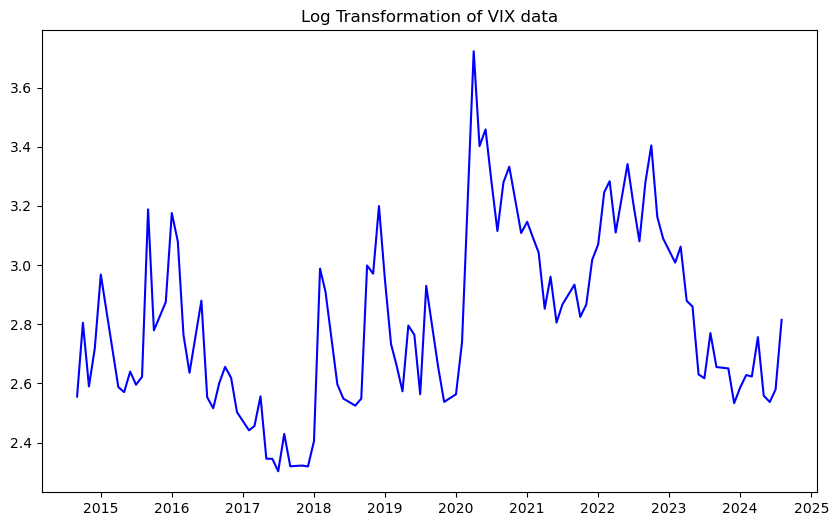

In [112]:
VIX_series_log = np.log(VIX_data)

plt.figure(figsize=(10,6))
plt.plot(VIX_series_log, color='blue')
plt.title('Log Transformation of VIX data')

VIX time series is not becoming stationary with Log transformation

Cross-Check on the stationarity by decomposing the time series 

In [113]:
#Decomposition
#Gives different components of the Time series data
VIX_series_decompose = seasonal_decompose(VIX_data, model='additive', period=21)

VIX_trend = VIX_series_decompose.trend
VIX_seasonal = VIX_series_decompose.seasonal
VIX_residual = VIX_series_decompose.resid

- Additive decomposition more appropriate for VIX series. The componenets (trend, seasonality and residuals) are added to form the original series

- Residuals in VIX decomposition typicall caputre the short-term fluctuations and random variations not explained by trend or seasonality

- Period=21. For monthly patterns in daily data (Approximate trading days in a month). We can do period=5 for weekly patterns in daily data and period=12 for yearly patterns in monthly data

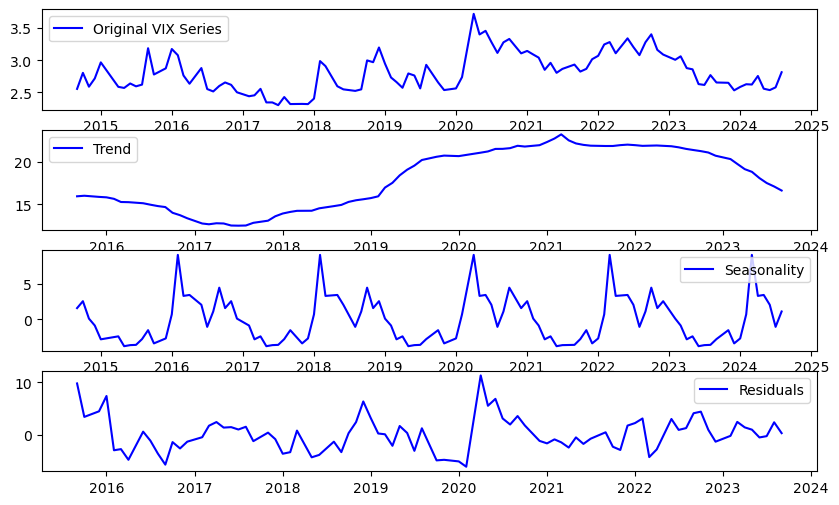

In [114]:
#Plot the decomposed time series
plt.figure(figsize=(10,6))

plt.subplot(411)
plt.plot(VIX_series_log, color='blue', label='Original VIX Series')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(VIX_trend, color='blue', label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(VIX_seasonal, color='blue', label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(VIX_residual, color='blue', label='Residuals')
plt.legend(loc='best')

Text(0.5, 1.0, 'Differenced VIX_log')

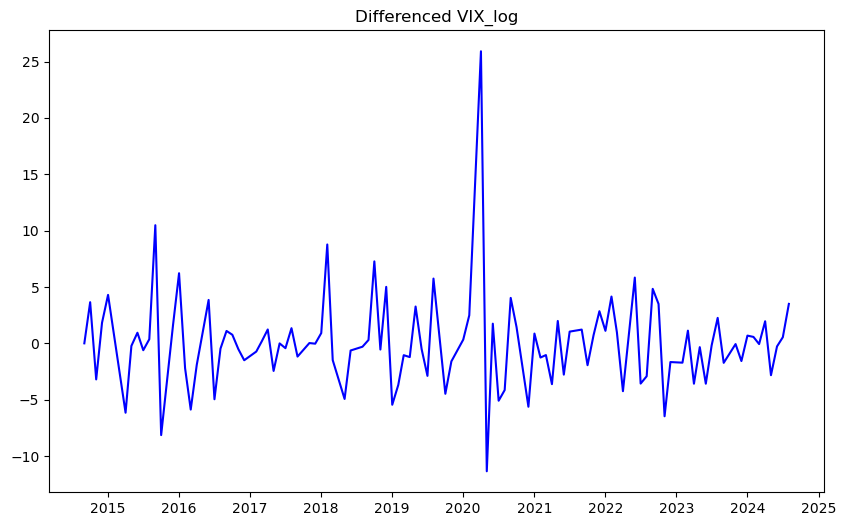

In [115]:
#Differencing
#Create a Differenced time series by Shifting the time series by 1 and subtract from the original time series
#We expect the differenced time series to be stationary 

VIX_data_diff = VIX_data - VIX_data.shift() #First-order differencing

VIX_data_diff.iloc[0] = 0 #First entry of differenced data is typically NaN because there is no previous value to subtract from the first observation

plt.figure(figsize=(10,6))
plt.plot(VIX_data_diff, color='blue')
plt.title('Differenced VIX_log')


- Differencing eliminates / reduces trends and some form of seasonality
- By subtracting consecutive values, the mean of the differenced series tends to be constant
- In many case, differencing can stabilize the variance of the series

+ ARIMA, SARIMAX require staitionary data as an assumption

Remember: After making predictions using the differenced data, reverse the differencing to obtain forecasts on the original scale

In [116]:
VIX_data_diff.describe()

count    104.000000
mean       0.036635
std        4.282209
min      -11.350000
25%       -1.917500
50%       -0.122500
75%        1.368750
max       25.910000
Name: VIX_x, dtype: float64

In [117]:
VIX_data_diff

Date
2014-09-01    0.000
2014-10-01    3.650
2014-11-01   -3.200
2014-12-01    1.825
2015-01-01    4.300
              ...  
2024-04-01    1.960
2024-05-01   -2.825
2024-06-01   -0.275
2024-07-01    0.545
2024-08-01    3.500
Name: VIX_x, Length: 104, dtype: float64

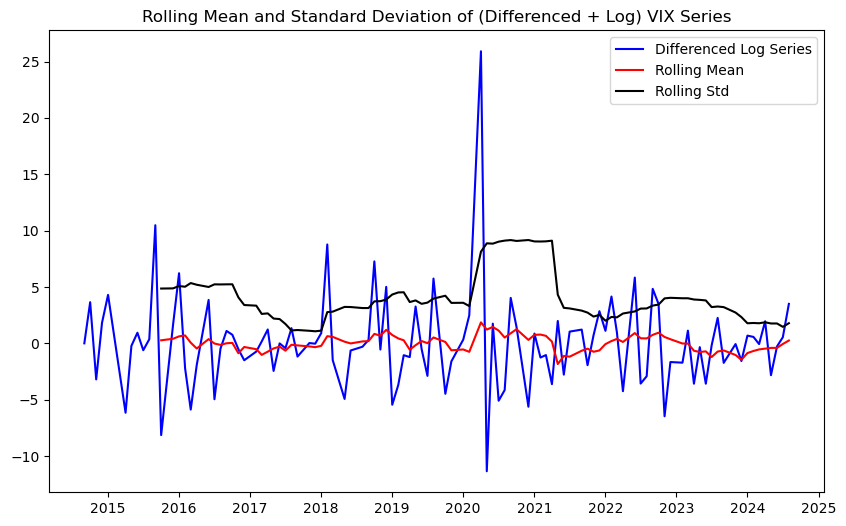

In [118]:
#Determine rolling statistics for the Differenced time series
rolLmean_diff = VIX_data_diff.rolling(12).mean()
rolLstd_diff = VIX_data_diff.rolling(12).std()

plt.figure(figsize=(10,6))
plt.plot(VIX_data_diff, color='blue', label='Differenced Log Series')
plt.plot(rolLmean_diff, color='red', label='Rolling Mean')
plt.plot(rolLstd_diff, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation of (Differenced + Log) VIX Series')
plt.show(block=False)

In [119]:
#Check for NaN or infinate values 
missing_values = VIX_data_diff.isnull().sum() + (VIX_data_diff == float('inf')).sum() + (VIX_data_diff == float('-inf')).sum()
print(f'Number of missing or infinite values: {missing_values}')

Number of missing or infinite values: 0


Cross Validate with Duckey Fueller Test

In [120]:
#ADF/ Augmented Dickey-Fuller test
adf_result = adfuller(VIX_data_diff)

#Extract test results
adf_statistic, p_value, _, _, critical_values, _ = adf_result

#Print the results
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'    {key}: {value}')

ADF Statistic: -6.871934624328735
p-value: 1.5078932220022642e-09
Critical Values:
    1%: -3.497501033
    5%: -2.89090644
    10%: -2.5824349


- Null hypothesis for ADF: There exists a unit root in the time series and it is non-stationary 

- A more negative number of ADF Statistic indicates stronger evidence against the null hypothesis of non-stationarity
- p-value represents teh probability of obtaining test results at least as extreme as the observed results, assuming that the null hypothesis is true
- Critical values are the threshold values for rejecting the null hypothesis at different significant levels

- If the test statistic is less than the critical value or if the p-value is less than pre-specified significance level (e.g., 0.05), then the null hypothesis is rejected, and the time series is considered stationary

In [121]:
#Interpret the ADF results
if p_value <= 0.01:
    print('The differenced VIX data is stationary (Reject the null hypothesis)')
else:
    print('The differenced VIX data is non-stationary (fail to reject the null hypothesis)')

The differenced VIX data is stationary (Reject the null hypothesis)


Determine optimal p and q values for an ARMA model
- ACF and PACF plots. Analyse Autocorrelation Function (ACF) and Patial Autocorrelation Function (PACF) to get the intial estimates of p and q
- Information Criteria. Use Akaike Information Criterion (AIF) or Bayesian Information Criterion (BIC) to compare different models

In [122]:
data = pd.Series(VIX_data_diff)

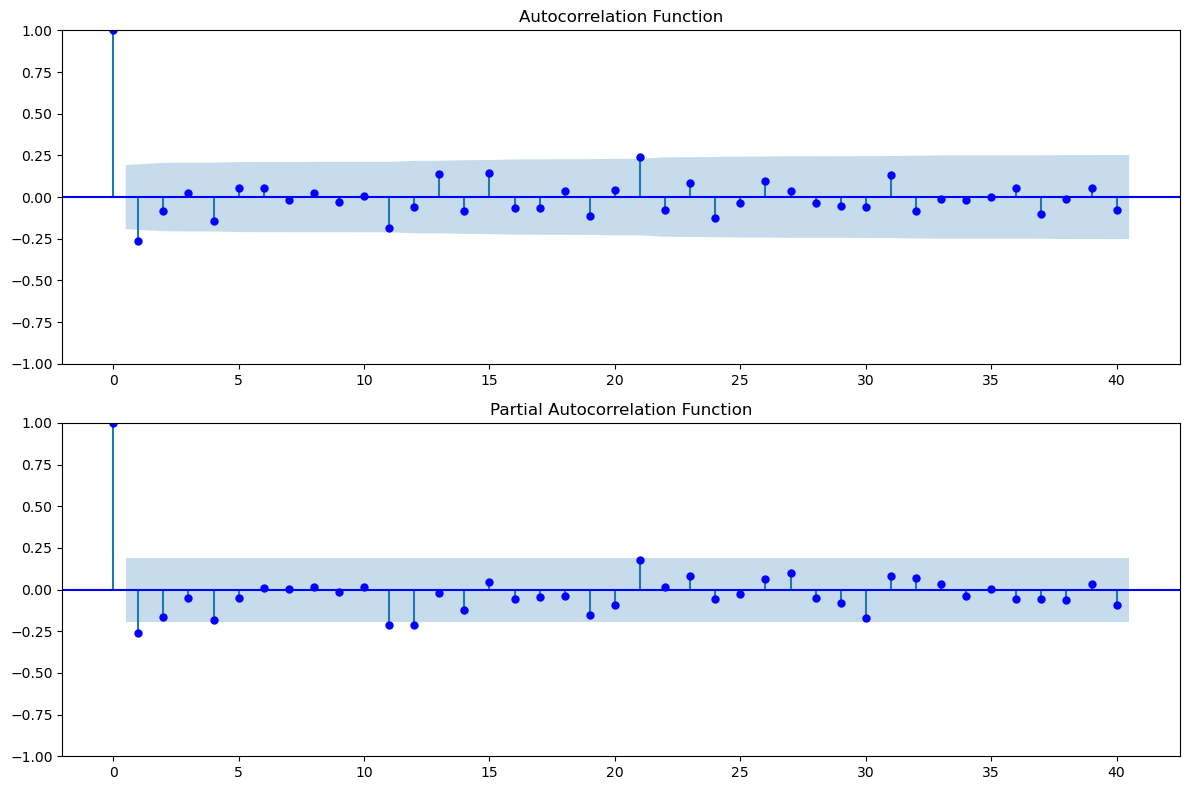

In [123]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

sm.graphics.tsa.plot_acf(data, lags=40, ax=ax1, color='blue')
ax1.set_title('Autocorrelation Function')

sm.graphics.tsa.plot_pacf(data, lags=40, ax=ax2, color='blue')
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

ACF plot:
- Shows how each lag of the time series is correlated with the current value
- Significant spike at lag 1 and then quickly falls within the confidence level. Suggest a possible MA(1) compoenent

PACF plot:
- Shows the correlation of the time series with its own lagged values, controlling for the values of the time series at all shorter lags
- Significant spike at lag 1 followed by values at within confidence internal. Suggest a possible AR(1) component

In [124]:
def evaluate_arma_model(data, p, q):
    model = ARIMA(data, order=(p, 0, q))
    results = model.fit()
    return results.aic, results.bic

In [136]:
p_values = range(0, 4)
q_values = range(0, 4)

aic_bic_results = []

for p in p_values:
    for q in q_values:
        try:
            aic, bic = evaluate_arma_model(data, p, q)
            aic_bic_results.append((p, q, aic, bic))
        except:
            continue


best_aic_model = min(aic_bic_results, key=lambda x:x[2])
best_bic_model = min(aic_bic_results, key=lambda x:x[3])

print(f'Best ARMA model by AIC: ARMA{best_aic_model[:2]} with AIC:{best_aic_model[2]}')
print(f'Best ARMA model by BIC: ARMA{best_bic_model[:2]} with AIC:{best_bic_model[3]}')

best_order = (best_aic_model[0], 0, best_aic_model[1])
model = ARIMA(data, order=best_order)
ARMA_results = model.fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dat

Best ARMA model by AIC: ARMA(1, 2) with AIC:590.3632263806385
Best ARMA model by BIC: ARMA(0, 1) with AIC:600.1405128574839


In [137]:
best_order

(1, 0, 2)

Text(0.5, 1.0, 'ARMA model')

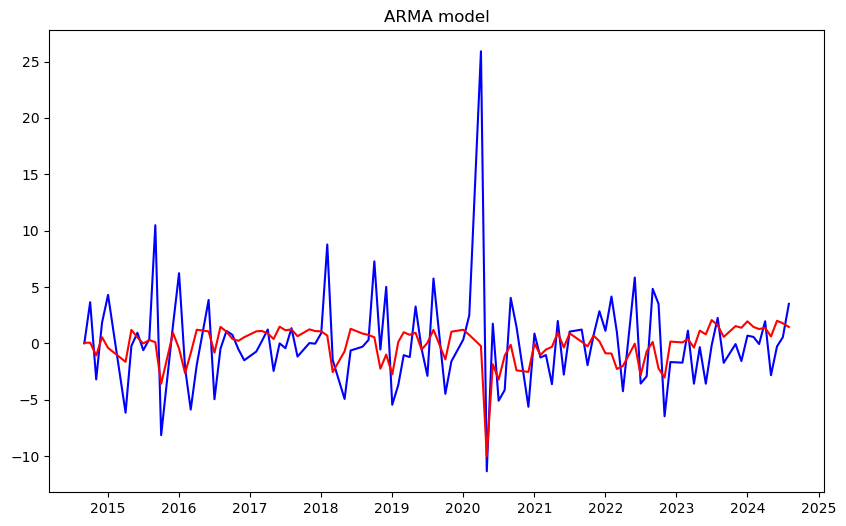

In [132]:
plt.figure(figsize=(10,6))
plt.plot(VIX_data_diff, color='blue')
plt.plot(ARMA_results.fittedvalues, color='red')
plt.title("ARMA model")


In [142]:
ARMA_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  VIX_x   No. Observations:                  104
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -290.182
Date:                Fri, 11 Oct 2024   AIC                            590.363
Time:                        14:23:30   BIC                            603.585
Sample:                             0   HQIC                           595.720
                                - 104                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0467      0.112      0.419      0.675      -0.172       0.265
ar.L1          0.8215      0.150      5.492      0.000       0.528       1.115
ma.L1         -1.2261     43.219     -0.028      0.977     -85.934      83.481
ma.L2          0.2262      9.815      0.023      0.982     -19.011      19.463
sigma2        15.1487    653.818      0.023      0.982   -1266.311    1296.609
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1423.60
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             3.17
Prob(H) (two-sided):                  0.54   Kurtosis:                        19.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""